***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine MNIST


*Created:* March 2, 2025


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [3]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,1,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    Theta["Theta_10"] = torch.zeros((n_dz[0],n_dz[1]+n_dz[0]-1),device=dev) # conditioning
    return Phi,Theta

In [4]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [5]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -20
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [10]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [11]:
def data_layer_train(input_x,param_xy,param_yx,seq,window_size,n_smp,lr,dev,random):
    """
    Arguments:
    input_x -- Layer 0 sample, torch tensor of shape (n_d,batch_size)
    param_xy -- parameters from Layer 0 to Layer 1. Torch tensor of shape (n_z1,n_d)
    param_yx -- parameters from Layer 1 and sampled values at Layer 0 to Layer 0. Torch tensor of shape (n_d,n_z1 + n_d - 1)
    lr -- learning rate
    dev -- torch device
    seq -- reordered index of the data layer neuron. Numpy array of shape (n_d, )
    window_size -- number of neurons sampled at each standard sampling time.
    n_smp -- number of times the data layer is sampled
    random -- condition on sampled value (True) or ground truth (False)
    
    Returns:
    output_y -- Layer 1 sample, torch tensor of shape (n_z1,batch_size)
    param_yx -- updated parameters from Layer 1 and sampled values at Layer 0 to Layer 0
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev) # Layer 1
    
    # train the opposite phase from x to y
    n_d = input_x.shape[0]
    n_z1 = param_xy.shape[0]
    loss = torch.zeros(n_smp,device=dev)
    samp = output_y
    
    diff_size = n_d - window_size*(n_smp-1)
    for i in range(n_smp):
        if i == 0:
            sample_index = seq[:diff_size]
        else:
            sample_index = seq[diff_size+(i-1)*window_size:diff_size+i*window_size]
            
        param_yx[sample_index,:samp.shape[0]], grad, loss[i] = one_step_update(samp,\
                    input_x[sample_index,:], param_yx[sample_index,:samp.shape[0]],lr)
        if random == True:
            gen = sample(one_step_forward(samp,param_yx[sample_index,:samp.shape[0]]),dev)
            samp = torch.cat((samp,gen),0) # (n_z1+i*(n_d/n_smp),batch_size)
        else:
            samp = torch.cat((samp,input_x[sample_index,:]),0)
    
    return output_y, param_yx, loss.mean()

In [12]:
def data_layer_gen(input_x,param_xy,param_yx,seq,window_size,n_smp,lr,dev):
    """
    Arguments:
    input_x -- Layer 1 sample, torch tensor of shape (n_z1,batch_size)
    param_xy -- parameters from Layer 1 and sampled values at Layer 0 to Layer 0. Torch tensor of shape (n_d,n_z1 + n_d - 1)
    param_yx -- parameters from Layer 0 to Layer 1. Torch tensor of shape (n_z1,n_d)
    lr -- learning rate
    dev -- torch device
    seq -- reordered index of the data layer neuron. Numpy array of shape (n_d, )
    window_size -- number of neurons sampled at each standard sampling time.
    n_smp -- number of times the data layer is sampled
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    n_d = param_xy.shape[0]
    batch_size = input_x.shape[1]
    output_y = torch.zeros(n_d,batch_size,device=dev,dtype=int)
    input_condition = input_x
    
    diff_size = n_d - window_size*(n_smp-1)
    for i in range(n_smp):
        if i == 0:
            sample_index = seq[:diff_size]
        else:
            sample_index = seq[diff_size+(i-1)*window_size:diff_size+i*window_size]
        
        output_y[sample_index,:] =sample(one_step_forward(input_condition,param_xy[sample_index,:input_condition.shape[0]]),dev)
        input_condition = torch.cat((input_condition,output_y[sample_index,:]),0)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [13]:
def wake_phase(Phi,Theta,data,seq,window_size,n_smp,lr,dev,cor,random):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    seq -- reordered index of the data layer neuron. Numpy array of shape (n_d, )
    window_size -- number of neurons sampled at each standard sampling time.
    n_smp -- number of times the data layer is sampled
    random -- condition on sampled value (True) or ground truth (False)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    n_z1 = Phi["Phi_01"].shape[0]
    if cor == True:
        output_y, Theta["Theta_10"], Loss[0] = data_layer_train(data,Phi["Phi_01"],Theta["Theta_10"],seq,window_size,n_smp,lr,dev,random)
    else:
        output_y, Theta["Theta_10"][:,:n_z1], Grad, Loss[0] = layer_wise_train(data,Phi["Phi_01"],Theta["Theta_10"][:,:n_z1],lr)
    input_x = output_y
    for i in range(1,n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [14]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
                    sample is of shape (n_y, batch_size)
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [15]:
def sleep_phase(Phi,Theta,gen_batch_size,seq,window_size,n_smp,lr,dev,cor):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    seq -- reordered index of the data layer neuron. Numpy array of shape (n_d, )
    window_size -- number of neurons sampled at each standard sampling time.
    n_smp -- number of times the data layer is sampled
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    n_z1 = Phi["Phi_01"].shape[0]
    for i in range(n_layer-2,1,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    if cor == True:
        output_y, Phi["Phi_01"], Grad, Loss[1] = data_layer_gen(input_x,Theta["Theta_10"],Phi["Phi_01"],seq,window_size,n_smp,lr,dev)
    else:
        output_y, Phi["Phi_01"], Grad, Loss[1] = layer_wise_train(input_x,Theta["Theta_10"][:,:n_z1],Phi["Phi_01"],lr)
    return Phi, Loss

In [16]:
def sleep_sample(Theta,gen_batch_size,seq,window_size,n_smp,dev,cor):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    cor -- add data layer correlation or not. Boolean value True or False.
    seq -- reordered index of the data layer neuron. Numpy array of shape (n_d, )
    window_size -- number of neurons sampled at each standard sampling time.
    n_smp -- number of times the data layer is sampled
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    n_d = Theta["Theta_10"].shape[0]
    n_z1 = Theta["Theta_21"].shape[0]
    for i in range(n_layer-1,1,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    if cor == False:
        Gen_sample["Layer_0"] = sample(one_step_forward(input_x,Theta["Theta_10"][:,:n_z1]),dev)
    else:
        Gen_sample["Layer_0"] = torch.zeros(n_d,gen_batch_size,device=dev,dtype=int)
        input_condition = input_x
        
        diff_size = n_d - window_size*(n_smp-1)
        for i in range(n_smp):
            if i == 0:
                sample_index = seq[:diff_size]
            else:
                sample_index = seq[diff_size+(i-1)*window_size:diff_size+i*window_size]
            Gen_sample["Layer_0"][sample_index,:] = sample(one_step_forward(input_condition,Theta["Theta_10"][sample_index,:input_condition.shape[0]]),dev)
            input_condition = torch.cat((input_condition,Gen_sample["Layer_0"][sample_index,:]),0)
    return Gen_sample

In [17]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [20]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [21]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [22]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [23]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [24]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [25]:
def sleep_entropy(Theta,gen_batch_size,seq,window_size,n_smp,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    seq -- reordered index of the data layer neuron. Numpy array of shape (n_d, )
    window_size -- number of neurons sampled at each standard sampling time.
    n_smp -- number of times the data layer is sampled
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,1,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    
    n_d = Theta["Theta_10"].shape[0]        
    q = torch.zeros(n_d,gen_batch_size,device=dev)
    input_condition = input_x
    
    diff_size = n_d - window_size*(n_smp-1)
    for i in range(n_smp):
        if i == 0:
            sample_index = seq[:diff_size]
        else:
            sample_index = seq[diff_size+(i-1)*window_size:diff_size+i*window_size]
        
        q[sample_index,:] = one_step_forward(input_condition,Theta["Theta_10"][sample_index,:input_condition.shape[0]])
        input_condition = torch.cat((input_condition,sample(q[sample_index,:],dev)),0)  
        
    H_Y_sleep[0], I_sleep[0] = one_step_prob_entropy(q)    
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

## Data

In [26]:
from torchvision import datasets, transforms

In [27]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [28]:
# Define the transformation to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.to(dev))])

In [29]:
# Load the MNIST dataset with the specified transformation
mnist_pytorch = datasets.MNIST(root='D:\deep music\MNIST', train=True, download=False, transform=transform)
mnist_pytorch

Dataset MNIST
    Number of datapoints: 60000
    Root location: D:\deep music\MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

In [30]:
train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size=10000, shuffle=True)

In [31]:
for i, (image, label) in enumerate(train_loader_pytorch):
    if i > 0:
        break

In [32]:
image.shape

torch.Size([10000, 1, 28, 28])

In [33]:
image.squeeze().shape

torch.Size([10000, 28, 28])

In [34]:
image_binary = (image.squeeze()>0.5).long()

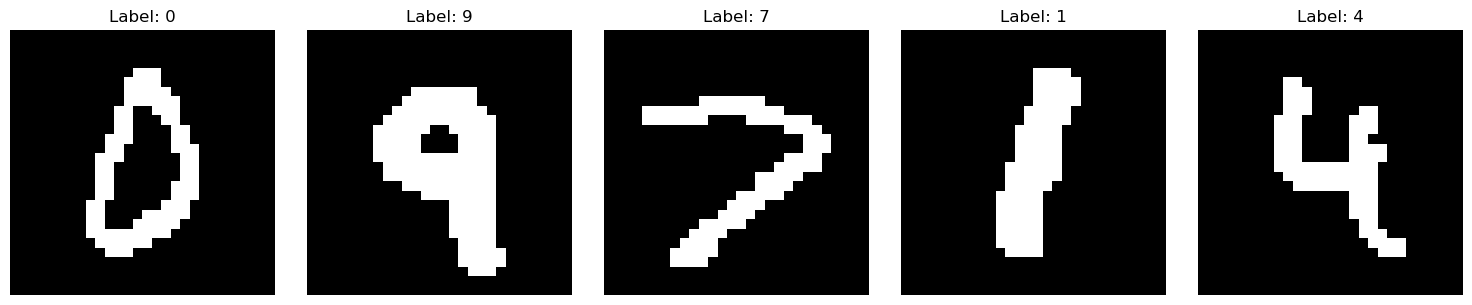

In [35]:
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_binary[i,:,:].to('cpu').numpy(), cmap='gray')
#         plt.imshow(image.squeeze()[i+300,:,:].to('cpu').numpy(), cmap='gray')
        plt.title(f"Label: {label[i].item()}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [36]:
# dataset = image_binary.reshape(-1,784).t()
# dataset.shape

## Model

In [37]:
structure = [784,588,392,196,98,49,20,1]
n_dz = torch.tensor(structure)
n_dz

tensor([784, 588, 392, 196,  98,  49,  20,   1])

In [38]:
n_layer = len(n_dz)
n_layer

8

In [39]:
n_d = n_dz[0]
n_d

tensor(784)

In [40]:
# Phi,Theta = para_init(n_dz)

In [41]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Recog_I_Layer_5',
 'Recog_I_Layer_6',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_H_Layer_4',
 'Gen_H_Layer_5',
 'Gen_H_Layer_6',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3',
 'Gen_I_Layer_4',
 'Gen_I_Layer_5',
 'Gen_I_Layer_6']

In [42]:
len(col_list)

38

### Train with Batch

In [42]:
# Analytic_MNIST = pd.DataFrame(columns=col_list)
# Analytic_MNIST

In [43]:
# Phi,Theta = para_init(n_dz)

In [39]:
Analytic_MNIST = pd.read_csv('Analytic_MNIST.csv', sep=",")
Analytic_MNIST

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Theta_Loss_Layer_4,Theta_Loss_Layer_5,Theta_Loss_Layer_6
0,0.693147,0.693147,0.693147,0.693147,0.693148,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693148,0.693147
1,0.693317,0.683769,0.693011,0.693138,0.693147,0.693149,0.389635,0.692143,0.684187,0.693050,0.693130,0.693146,0.693147
2,0.686069,0.680391,0.692888,0.693121,0.693148,0.693147,0.356146,0.660805,0.680678,0.692935,0.693123,0.693146,0.693147
3,0.682944,0.679950,0.692806,0.693109,0.693150,0.693149,0.417421,0.660603,0.680107,0.692867,0.693089,0.693146,0.693146
4,0.656564,0.679859,0.692749,0.693090,0.693150,0.693148,0.387384,0.615332,0.680220,0.692828,0.693089,0.693146,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,0.069054,0.075100,0.312944,0.377183,0.621193,0.495117,0.096787,0.078880,0.084784,0.324120,0.403654,0.641292,0.576726
3794,0.068957,0.075088,0.313078,0.377284,0.621241,0.495372,0.096708,0.078855,0.084827,0.323794,0.403842,0.641440,0.576663
3795,0.069196,0.075075,0.313267,0.377089,0.621154,0.495030,0.096713,0.078836,0.084776,0.323906,0.403996,0.641265,0.575873
3796,0.069220,0.074943,0.313569,0.376639,0.621183,0.496101,0.096638,0.078769,0.084717,0.323857,0.403818,0.641393,0.575894


In [43]:
para = torch.load('Parameters_MNIST', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [162]:
batch_size = 1000
gen_batch_size = 100000
lr = 0.1
epoch = 10000

In [46]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size = batch_size, shuffle=True)
    for i, (image, label) in enumerate(train_loader_pytorch):
        data = (image.squeeze()>0.5).long().reshape(-1,784).t()
        if e%5 == 0:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=True)
            Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=True)
        else:
            Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,cor=False)
            Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev,cor=False)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/(i+1),'    Loss_sleep:',Loss_S/(i+1))
    if e % 50 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/(i+1)).to('cpu').numpy())
        stat = stat + list((Loss_S/(i+1)).to('cpu').numpy())
        
        H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev)
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
        
        Analytic_MNIST_batch_10000_1000_cor.loc[len(Analytic_MNIST_batch_10000_1000_cor)] = stat
        
        parameters = {'Phi': Phi, 'Theta': Theta}
        torch.save(parameters,'Parameters_MNIST_batch_10000_1000_cor')
        Analytic_MNIST_batch_10000_1000_cor.to_csv('Analytic_MNIST_batch_10000_1000_cor.csv', index = False)

Loss_wake: tensor([0.0000, 0.0877, 0.0445, 0.0993, 0.1569, 0.3541, 0.2274])     Loss_sleep: tensor([0.0688, 0.0970, 0.0633, 0.1142, 0.1770, 0.4005, 0.6104])
Loss_wake: tensor([0.0000, 0.0878, 0.0444, 0.1000, 0.1559, 0.3559, 0.2272])     Loss_sleep: tensor([0.0700, 0.0962, 0.0636, 0.1139, 0.1776, 0.4006, 0.6103])
Loss_wake: tensor([0.0000, 0.0870, 0.0446, 0.0996, 0.1566, 0.3548, 0.2273])     Loss_sleep: tensor([0.0698, 0.0962, 0.0635, 0.1140, 0.1776, 0.4007, 0.6097])
Loss_wake: tensor([0.0000, 0.0872, 0.0447, 0.0999, 0.1565, 0.3551, 0.2278])     Loss_sleep: tensor([0.0698, 0.0962, 0.0636, 0.1141, 0.1776, 0.4008, 0.6110])
Loss_wake: tensor([0.0000, 0.0876, 0.0444, 0.1005, 0.1556, 0.3569, 0.2273])     Loss_sleep: tensor([0.0699, 0.0962, 0.0635, 0.1141, 0.1778, 0.4004, 0.6106])
Loss_wake: tensor([0.0000, 0.0885, 0.0442, 0.1001, 0.1566, 0.3547, 0.2288])     Loss_sleep: tensor([0.0680, 0.0972, 0.0631, 0.1145, 0.1773, 0.4002, 0.6101])


KeyboardInterrupt: 

In [47]:
Analytic_MNIST_batch_10000_1000_cor

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,...,Gen_H_Layer_3,Gen_H_Layer_4,Gen_H_Layer_5,Gen_H_Layer_6,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6
0,0.069203,0.074956,0.313479,0.377178,0.621140,0.495523,0.096695,0.078837,0.084838,0.323889,...,72.284040,42.445774,32.527344,5.771215,107.847760,25.983086,13.668011,8.502399,2.949772,1.086367
1,0.069420,0.074641,0.313244,0.376898,0.620649,0.494108,0.096680,0.078848,0.084744,0.323113,...,72.204290,42.461110,32.513195,5.769179,108.009030,26.042477,13.725407,8.550182,2.973953,1.101143
2,0.069249,0.074505,0.312480,0.378325,0.619694,0.493664,0.096550,0.078820,0.084433,0.322815,...,72.127840,42.643105,32.488205,5.771420,108.371760,26.144306,13.764267,8.585934,2.986313,1.120054
3,0.069542,0.074225,0.311776,0.378792,0.619552,0.493076,0.096398,0.078765,0.084295,0.321863,...,72.105225,42.743607,32.477783,5.776152,108.059586,26.238205,13.793602,8.657848,3.019268,1.134579
4,0.069367,0.074373,0.311253,0.380195,0.618905,0.493396,0.096483,0.078798,0.084151,0.322001,...,72.062330,42.832750,32.474434,5.779437,108.170580,26.217724,13.809578,8.666180,3.031269,1.141701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,0.087806,0.044711,0.100057,0.156349,0.355687,0.229183,0.069753,0.096549,0.063623,0.114223,...,39.409298,28.959213,28.598461,6.121440,136.740250,49.122158,25.120199,16.461723,11.370928,8.917418
826,0.087489,0.044659,0.100085,0.156344,0.355403,0.229542,0.069797,0.096576,0.063595,0.114401,...,39.459518,28.866039,28.624702,6.122207,136.314636,49.023823,25.107016,16.452740,11.398605,8.894205
827,0.087415,0.044781,0.100126,0.156737,0.354969,0.227854,0.069794,0.096411,0.063584,0.114267,...,39.469513,28.895012,28.599728,6.110082,136.355286,49.063591,25.077591,16.448839,11.378349,8.875990
828,0.087322,0.044725,0.100333,0.157145,0.356001,0.227688,0.069760,0.096300,0.063504,0.114586,...,39.466572,28.998377,28.628056,6.096478,136.484589,48.972118,25.140198,16.445206,11.418282,8.904346


In [133]:
parameters = {'Phi': Phi, 'Theta': Theta}
torch.save(parameters,'Parameters_MNIST_batch_10000_1000_cor')

In [134]:
Analytic_MNIST_batch_10000_1000_cor.to_csv('Analytic_MNIST_batch_10000_1000_cor.csv', index = False)

In [45]:
order = np.array([0,7,3,11,1,5,9,13,2,6,10,4,12,8,14])
seq = np.array([],dtype=int)
for i in range(order.size):
    seq = np.concatenate((seq,np.arange(order[i],n_d,order.size)))
n_smp_total = 15
window_size = int(n_d/n_smp_total)
window_size

52

In [46]:
n_smp = 15

In [60]:
gen_batch_size = 10
gen = sleep_sample(Theta,gen_batch_size,seq,window_size,n_smp,dev,cor=True)['Layer_0']
gen.shape

torch.Size([784, 10])

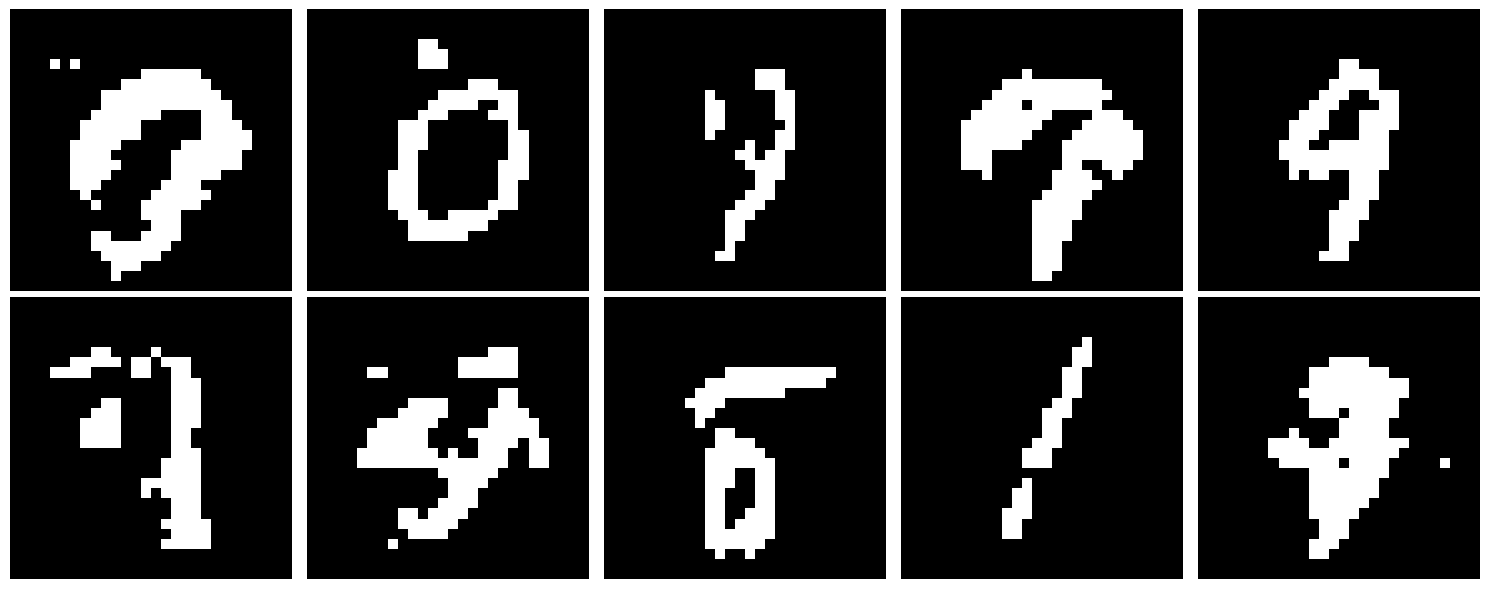

In [61]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

## Plot Analytics

In [41]:
# Analytic_MNIST = pd.read_csv('Analytic_MNIST.csv', sep=",")
Analytic = Analytic_MNIST
n_all = len(Analytic_MNIST)
n_all/5

759.6

In [54]:
# fig, ax = plt.subplots(figsize=(18, 12))
# ax.plot(np.concatenate((np.array(Analytic_MNIST['Theta_Loss_Layer_'+str(0)])[np.arange(0,n_all,5)], \
#                        np.array(Analytic['Theta_Loss_Layer_'+str(0)]))),label = 'Theta_Loss_Layer_'+str(0))
# for i in range(1,n_layer-1):
#     ax.plot(np.concatenate((np.array(Analytic_MNIST['Phi_Loss_Layer_'+str(i)])[np.arange(0,n_all,5)], \
#                            np.array(Analytic['Phi_Loss_Layer_'+str(i)]))),label = 'Phi_Loss_Layer_'+str(i))
#     ax.plot(np.concatenate((np.array(Analytic_MNIST['Theta_Loss_Layer_'+str(i)])[np.arange(0,n_all,5)], \
#                            np.array(Analytic['Theta_Loss_Layer_'+str(i)]))), label = 'Theta_Loss_Layer_'+str(i))
# ax.legend()
# plt.show()

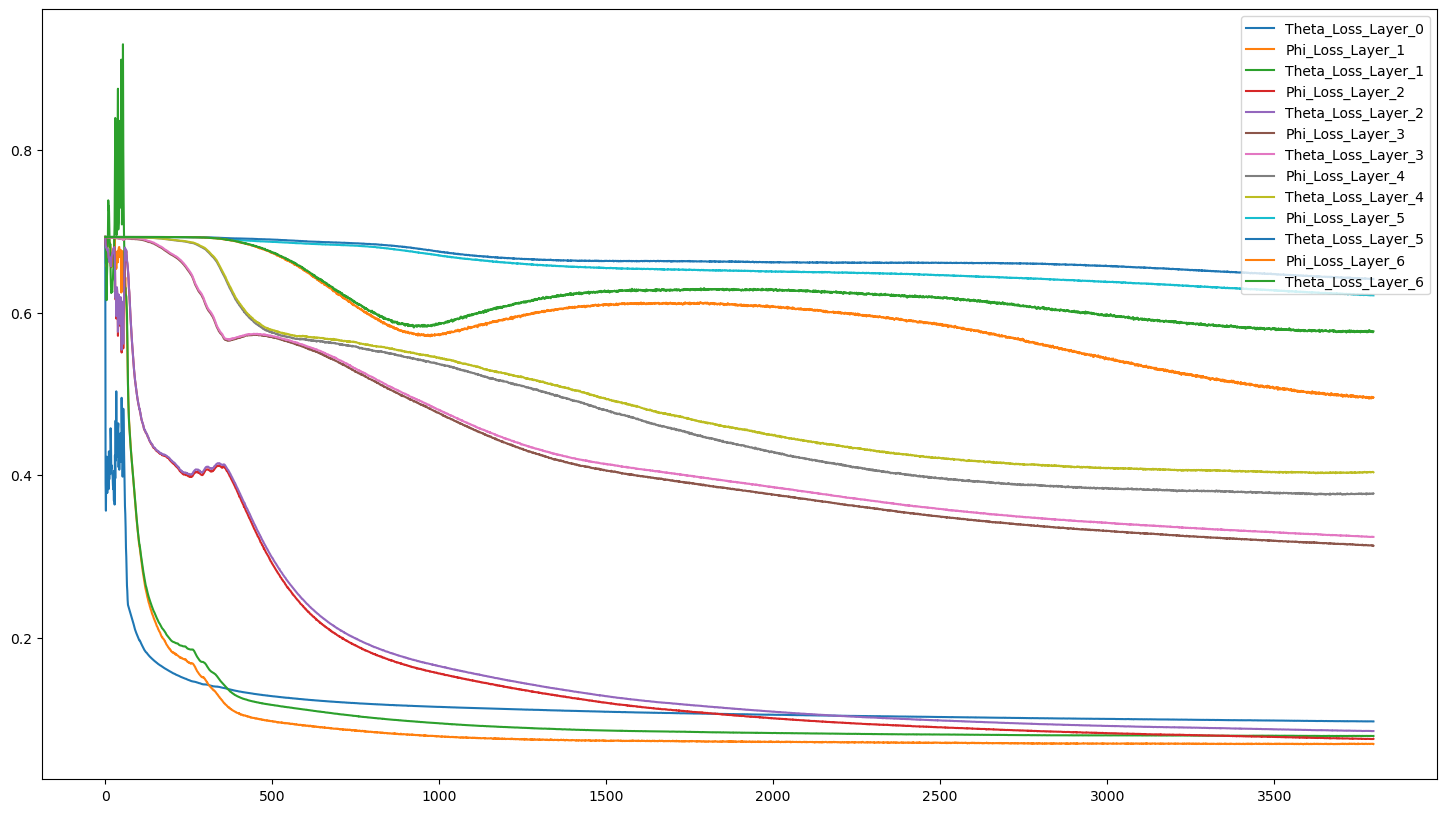

In [42]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

KeyError: 'Recog_I_Layer_1'

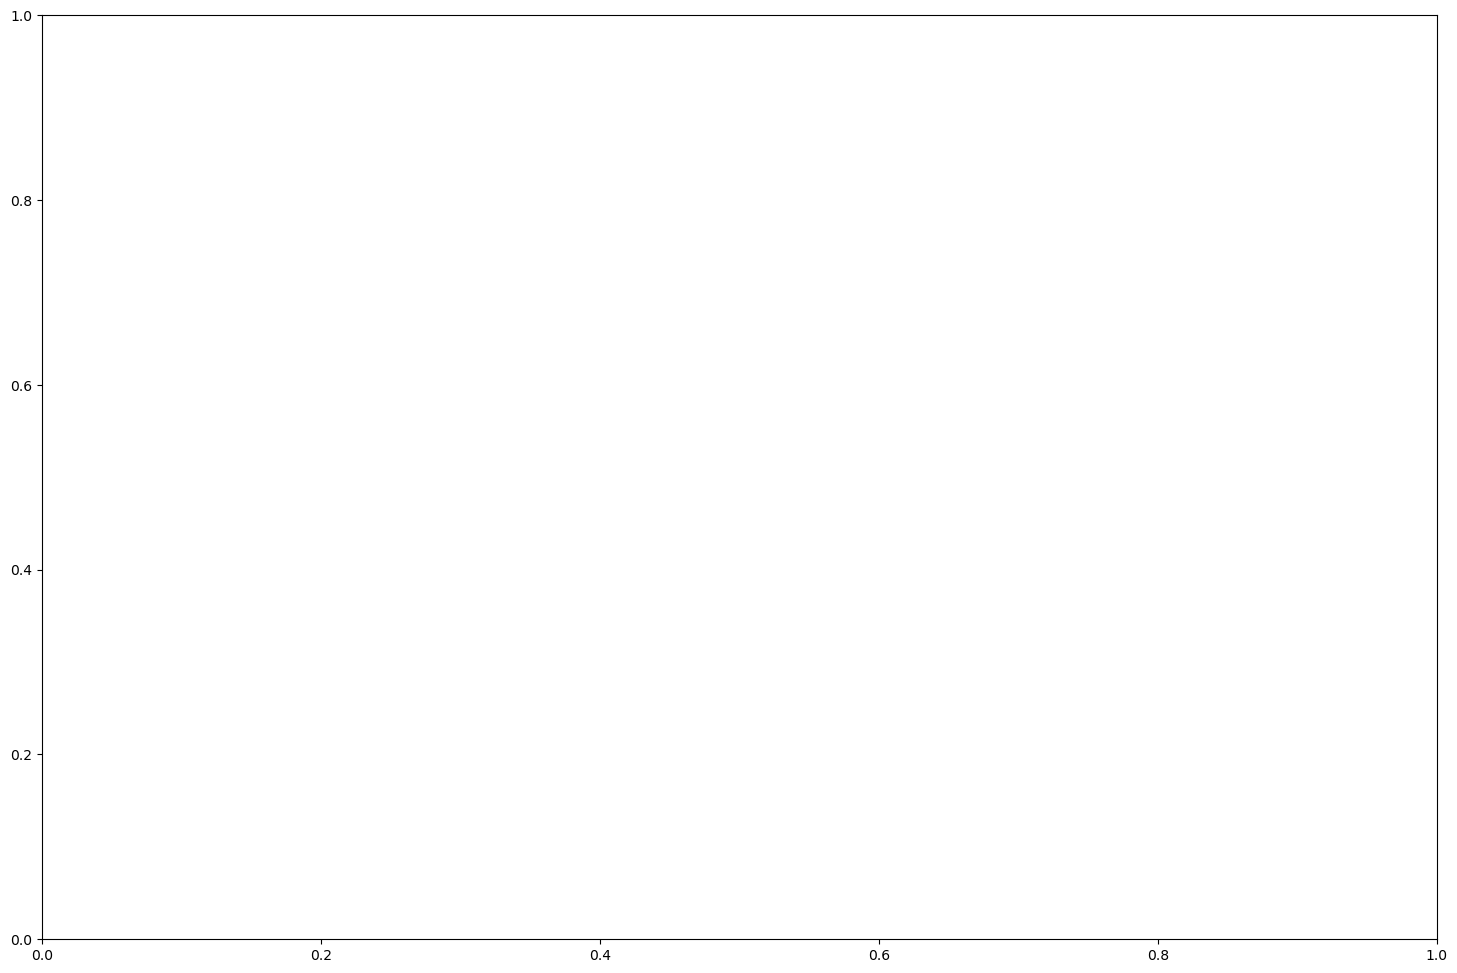

In [43]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

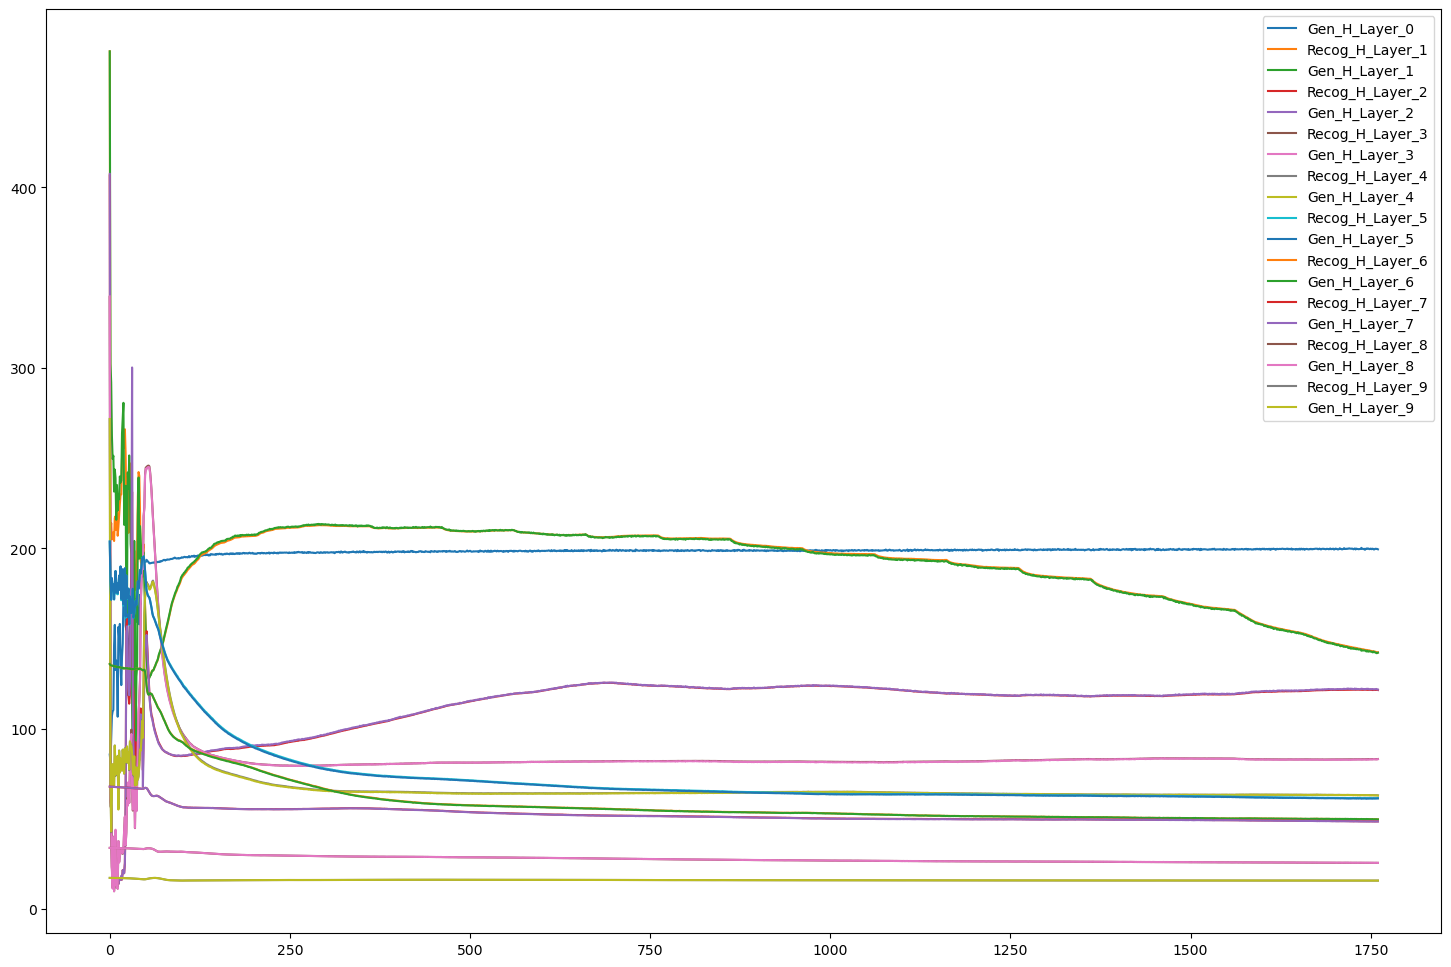

In [52]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [53]:
n_dz * np.log(2)

tensor([543.4274, 475.4990, 407.5706, 339.6421, 271.7137, 203.7853, 135.8568,
         67.9284,  33.9642,  17.3287,   0.6931])

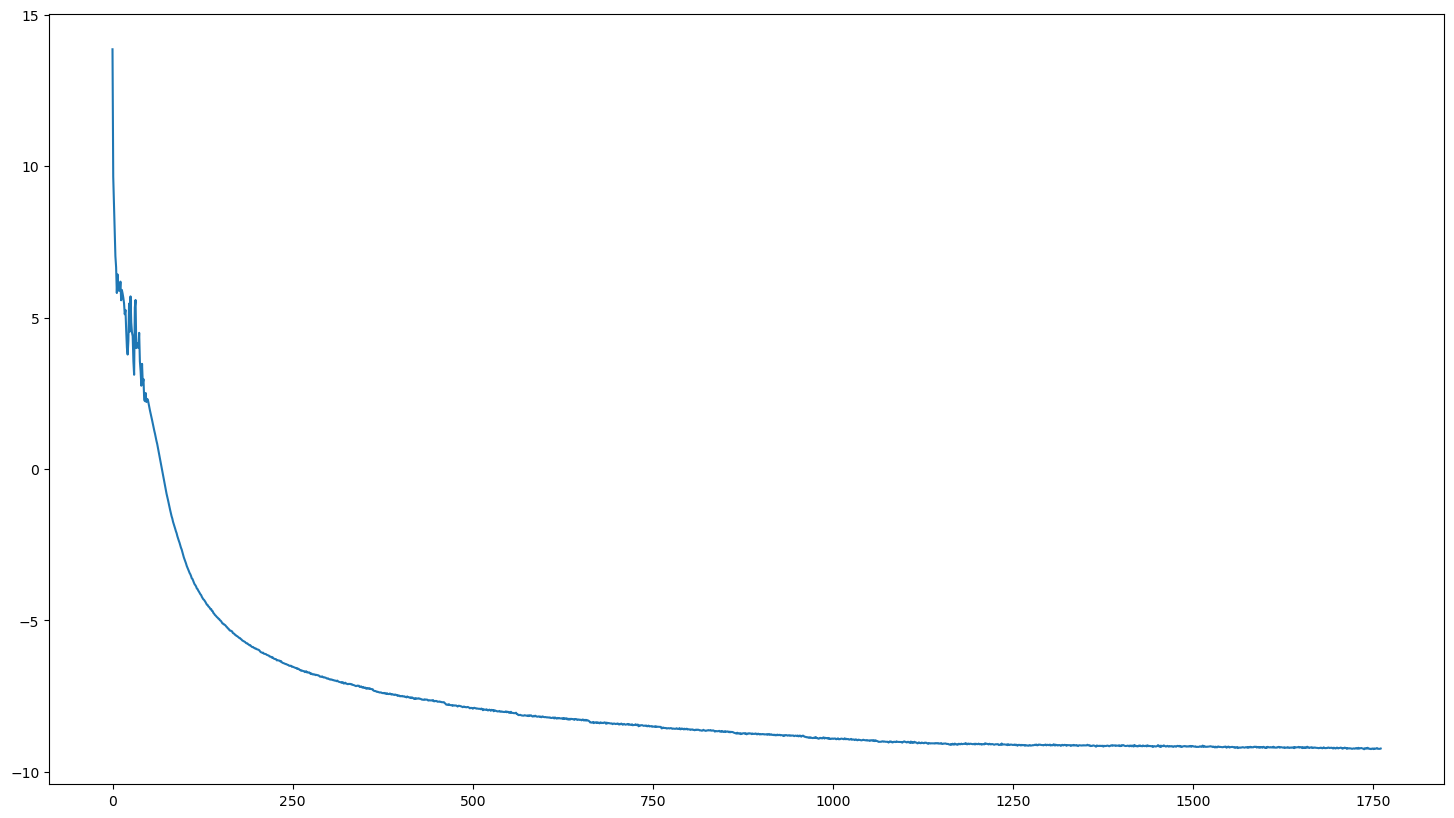

In [54]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

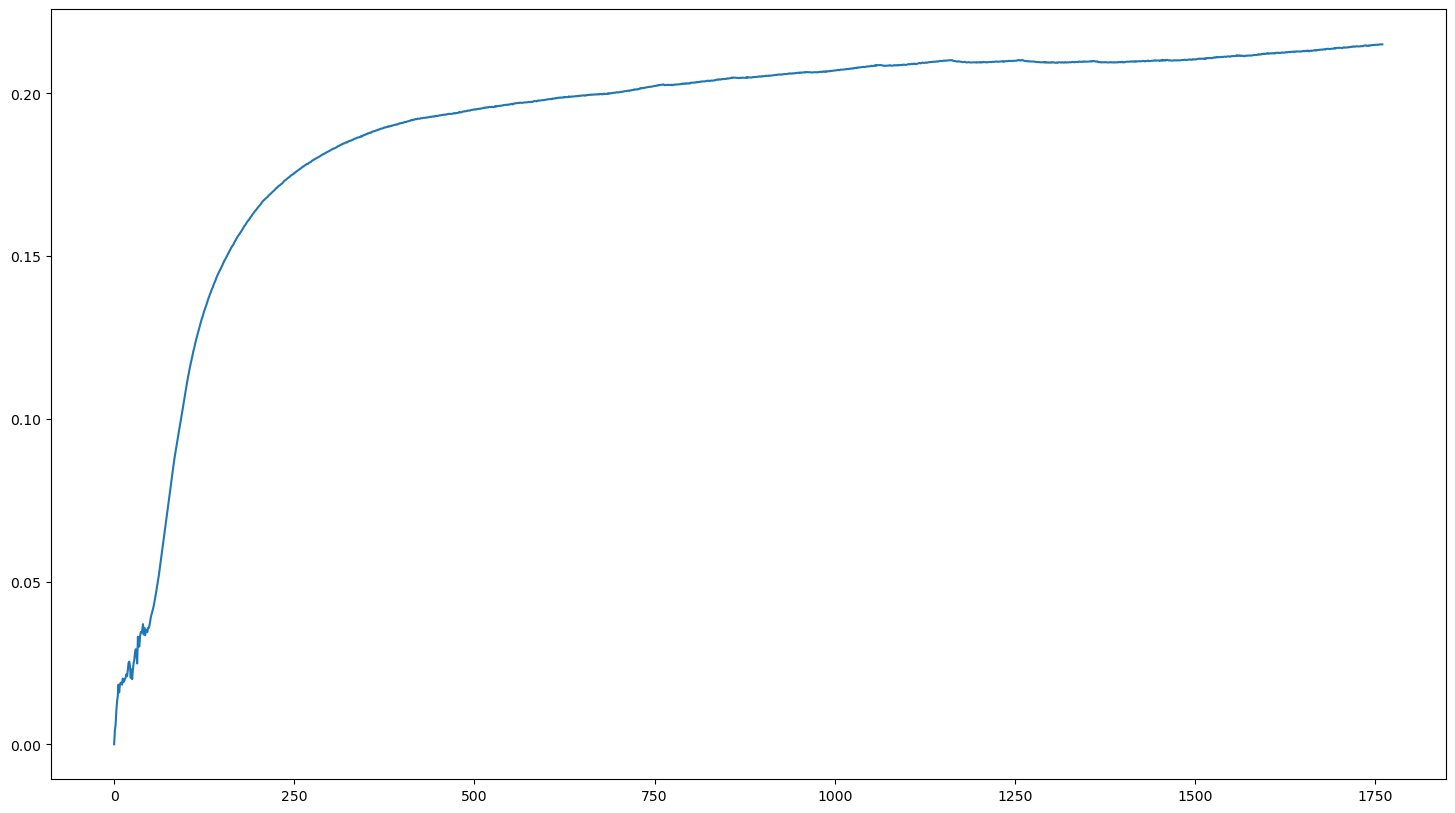

In [55]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()